In [1]:
import torch, copy
import torch.nn as nn
from lc_dlora import SYNTHETIC_DATASET_CONFIG, generate_synthetic_dataloader
from lc_dlora import CheckpointManager
from lc_dlora.lora import LoraManager, AutoLoraModel
from lc_dlora.lc import DeltaManager
from lc_dlora.metrics import accuracy_binary
import matplotlib.pyplot as plt
import torchinfo as tinf

# 1. Create Training Configurations + Model

In [2]:
"""
SYNTHETIC_DATASET_CONFIG = Config({
        "epochs" :  1,
        "scaling" : 0.5,
        "branch_path" : "/volumes/Ultra Touch/branchpoints/",
        "main_dir" : "/volumes/Ultra Touch/dlora/checkpoints/",
        "decomposed_layers" : ['linear_relu_stack.2', 'linear_relu_stack.4', 'linear_relu_stack.6',
                      'linear_relu_stack.8', 'linear_relu_stack.10'],
        "rank" : 8,
        "device" : "cpu", 
        "learning_rate" : 0.01,
        "lc_bw" : 3,
        "super_step" : 10,
        "training_log" : "/volumes/Ultra Touch/dlora/logs/",
        "base_path" : "/volumes/Ultra Touch/dlora/checkpoints/",
        "in_training_validation" : True,
        "validation_frequency" : 3,
        "loss_function" : "binary_cross_entropy",
        "optimizer" : "sgd",
        "evaluation_function" : "binary_accuracy"
    })
"""

'\nSYNTHETIC_DATASET_CONFIG = Config({\n        "epochs" :  1,\n        "scaling" : 0.5,\n        "branch_path" : "/volumes/Ultra Touch/branchpoints/",\n        "branch_dir" : "/volumes/Ultra Touch/dlora/checkpoints/",\n        "decomposed_layers" : [\'linear_relu_stack.2\', \'linear_relu_stack.4\', \'linear_relu_stack.6\',\n                      \'linear_relu_stack.8\', \'linear_relu_stack.10\'],\n        "rank" : 8,\n        "device" : "cpu", \n        "learning_rate" : 0.01,\n        "lc_bw" : 3,\n        "super_step" : 10,\n        "training_log" : "/volumes/Ultra Touch/dlora/logs/",\n        "base_path" : "/volumes/Ultra Touch/dlora/checkpoints/",\n        "in_training_validation" : True,\n        "validation_frequency" : 3,\n        "loss_function" : "binary_cross_entropy",\n        "optimizer" : "sgd",\n        "evaluation_function" : "binary_accuracy"\n    })\n'

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Linear(1024,  2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
model = NeuralNetwork()
model.state_dict().keys()

odict_keys(['linear_relu_stack.0.weight', 'linear_relu_stack.0.bias', 'linear_relu_stack.2.weight', 'linear_relu_stack.2.bias', 'linear_relu_stack.4.weight', 'linear_relu_stack.4.bias', 'linear_relu_stack.6.weight', 'linear_relu_stack.6.bias', 'linear_relu_stack.8.weight', 'linear_relu_stack.8.bias', 'linear_relu_stack.10.weight', 'linear_relu_stack.10.bias', 'linear_relu_stack.12.weight', 'linear_relu_stack.12.bias'])

# 2. Create Synthetic Dataset

In [5]:
dataset_1 = torch.normal(mean=0, std=1, size=(10000, 2)).numpy()
dataset_1_labels = torch.full(size=(10000,1), fill_value=1)
dataset_2 = torch.normal(mean=5, std=1, size=(10000, 2)).numpy()
dataset_2_labels = torch.full(size=(10000,1), fill_value=2)

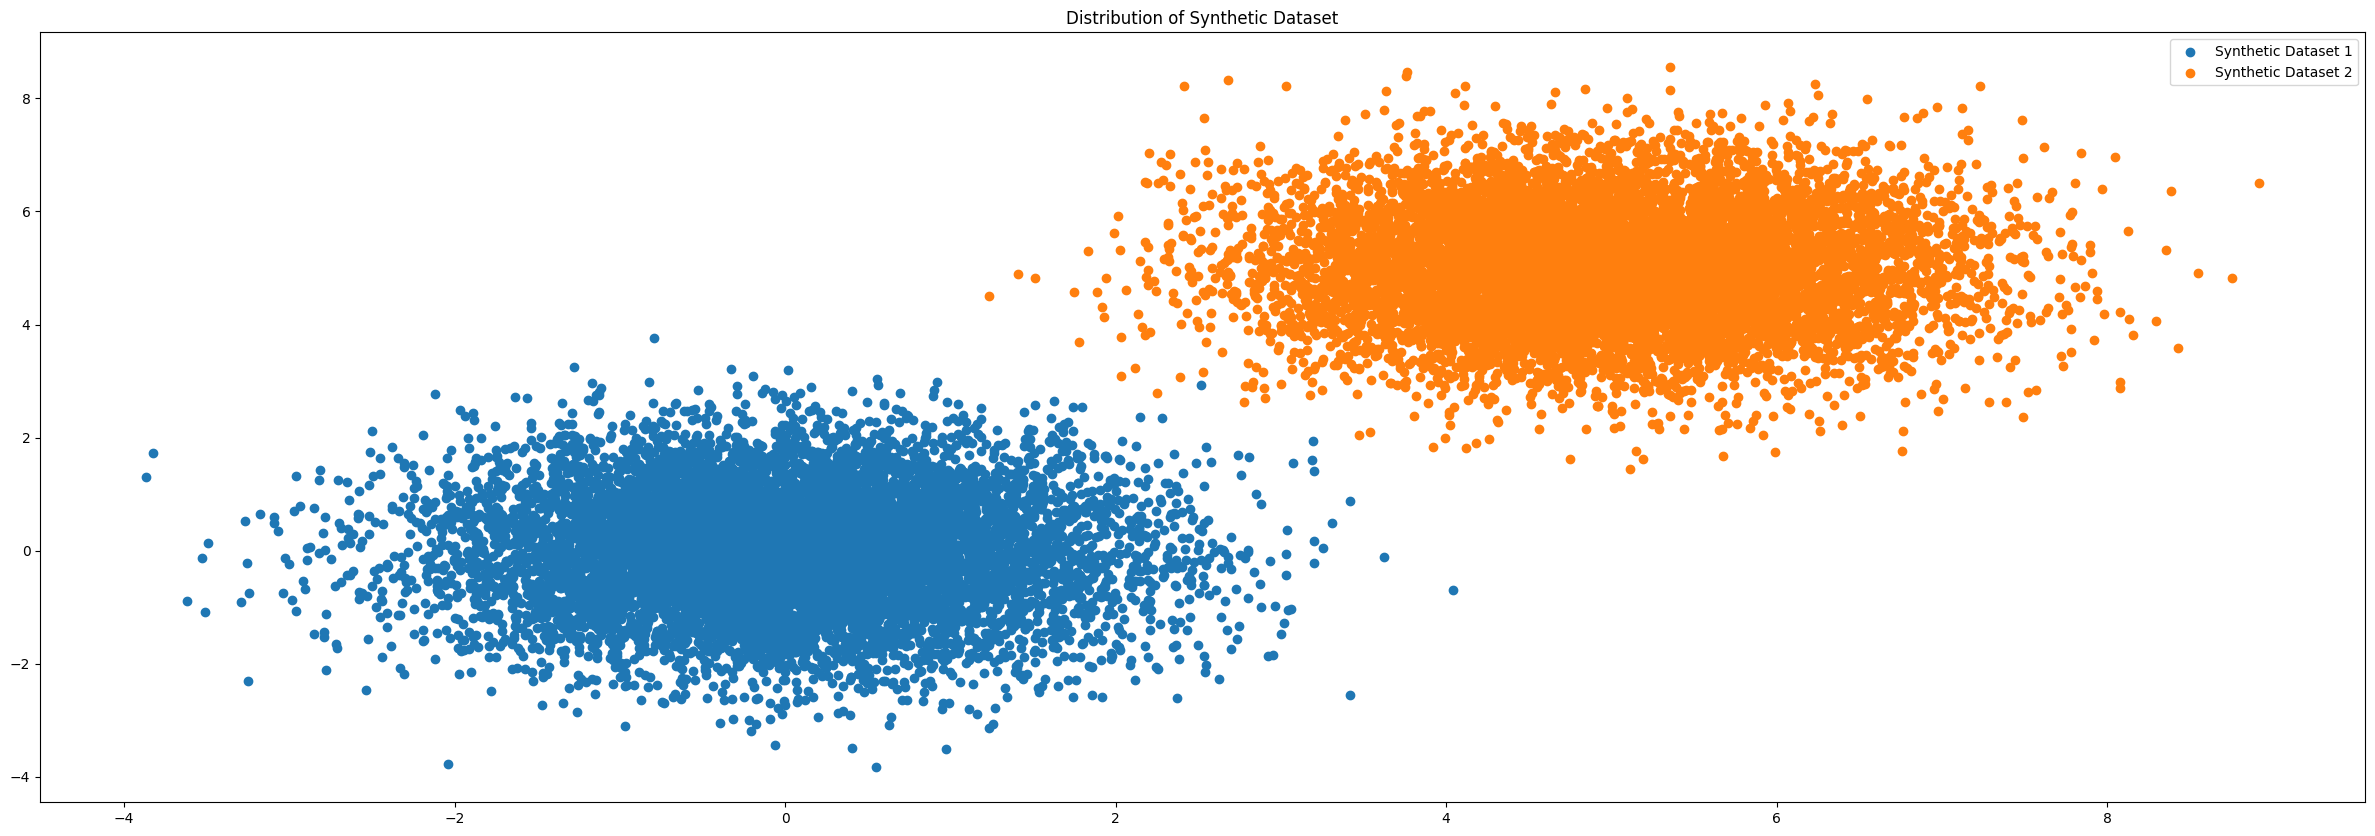

In [6]:
plt.figure(figsize=(30,10))
plt.title("Distribution of Synthetic Dataset")
plt.scatter(dataset_1[:, 0], dataset_1[:, 1], label="Synthetic Dataset 1")
plt.scatter(dataset_2[:, 0], dataset_2[:, 1], label="Synthetic Dataset 2")
plt.legend(loc="upper right")
plt.show()

In [7]:
train_loader, validation_loader = generate_synthetic_dataloader(0, 5, 1, 1)

Full data : 19000 | Validation data : 1000


# 3. Generate Branching Point

In [7]:
model = NeuralNetwork()
isLoop = True
optimizer = torch.optim.SGD(model.parameters(), lr = SYNTHETIC_DATASET_CONFIG.learning_rate)
for epoch in range(1):
    for iter, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.BCELoss()(torch.sigmoid(outputs), labels)
        loss.backward()
        optimizer.step()
        if iter % 20 == 0:
            print("Running validation for {} Epoch, {} Iteration...".format(epoch, iter))
            res_lora = accuracy_binary(model, validation_loader)
            print("ACCURACY: {}".format(res_lora))
            if res_lora > 0.7:
                torch.save(model.state_dict(), "/volumes/Ultra Touch/dlora/branchpoints/model_{}.pt".format(res_lora))
            if res_lora > 0.9:
                isLoop = False
                break
    if not isLoop:
        break

Running validation for 0 Epoch, 0 Iteration...
ACCURACY: 0.5141129032258065
Running validation for 0 Epoch, 20 Iteration...
ACCURACY: 0.8306451612903226
Running validation for 0 Epoch, 40 Iteration...
ACCURACY: 0.6098790322580645
Running validation for 0 Epoch, 60 Iteration...
ACCURACY: 0.6945564516129032
Running validation for 0 Epoch, 80 Iteration...
ACCURACY: 0.7913306451612904
Running validation for 0 Epoch, 100 Iteration...
ACCURACY: 0.8659274193548387
Running validation for 0 Epoch, 120 Iteration...
ACCURACY: 0.8971774193548387
Running validation for 0 Epoch, 140 Iteration...
ACCURACY: 0.9274193548387096


#### 3.1. Comparing LoRA structure

In [24]:
tinf.summary(model)

Layer (type:depth-idx)                   Param #
NeuralNetwork                            --
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       3,072
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       2,099,200
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       8,392,704
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       16,781,312
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       8,390,656
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      2,098,176
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      1,025
Total params: 37,766,145
Trainable params: 37,766,145
Non-trainable params: 0

In [25]:
lora_model = AutoLoraModel(model, SYNTHETIC_DATASET_CONFIG)

In [26]:
tinf.summary(lora_model)

Layer (type:depth-idx)                   Param #
AutoLoraModel                            --
├─ParameterDict: 1-1                     --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       3,072
│    └─ReLU: 2-3                         --
│    └─DecomposedLinear: 2-4             26,624
│    └─ReLU: 2-5                         --
│    └─DecomposedLinear: 2-6             53,248
│    └─ReLU: 2-7                         --
│    └─DecomposedLinear: 2-8             69,632
│    └─ReLU: 2-9                         --
│    └─DecomposedLinear: 2-10            51,200
│    └─ReLU: 2-11                        --
│    └─DecomposedLinear: 2-12            25,600
│    └─ReLU: 2-13                        --
│    └─Linear: 2-14                      1,025
Total params: 230,401
Trainable params: 230,401
Non-trainable params: 0

# 4. Sanity Check on Internal Classes

This whole process is encapsulated by Trainer.train(), see section 5.

In [13]:
# load model
full_model = NeuralNetwork()
full_model.load_state_dict(torch.load("/volumes/Ultra Touch/dlora/branchpoints/model_0.7913306451612904.pt"))
model = NeuralNetwork()
model.load_state_dict(full_model.state_dict()) # Ensure same initial state dictionary

full_acc = []
lora_acc = []

epochs = SYNTHETIC_DATASET_CONFIG.epochs
set_id, node_id = 0, 0
lora_manager = LoraManager(model, SYNTHETIC_DATASET_CONFIG)
checkpoint_manager = CheckpointManager(SYNTHETIC_DATASET_CONFIG)
checkpoint_manager.save_base(model)
lora_model = lora_manager.createLoraModelFromBase()
initial_bases = lora_manager.extractLoraDeltaBases(lora_model)
delta_manager = DeltaManager(SYNTHETIC_DATASET_CONFIG, initial_bases)  

# Initial superstep save.
checkpoint_manager.save_super_step(sd=lora_model.state_dict(), 
                                   set_id=set_id, iteration=0, epoch=0)
optimizer_full = torch.optim.SGD(full_model.parameters(), lr = SYNTHETIC_DATASET_CONFIG.learning_rate)
optimizer = torch.optim.SGD(lora_model.parameters(), lr = SYNTHETIC_DATASET_CONFIG.learning_rate)
loss_function = torch.nn.BCELoss()
loss_function_full = torch.nn.BCELoss()
evaluation_function = accuracy_binary

In [ ]:
inLoop = True

# Mirror training on synthetic dataset.
for epoch in range(epochs):
    for iter, data in enumerate(train_loader):
        print("Epoch {} | Iteration {}".format(epoch, iter))

        # Training LoRA
        inputs, labels = data
        optimizer.zero_grad()
        outputs = lora_model(inputs)
        loss = loss_function(torch.sigmoid(outputs), labels)
        loss.backward()
        optimizer.step()

        # Training full
        optimizer_full.zero_grad()
        outputs_full = full_model(inputs)
        loss_full = loss_function_full(torch.sigmoid(outputs_full), labels)
        loss_full.backward()
        optimizer_full.step()

        # LoRA save

        if node_id == SYNTHETIC_DATASET_CONFIG.super_step: # Superstep
            print('merging superstep!')
            set_id, node_id = set_id + 1, 0
            checkpoint_manager.save_super_step(sd=lora_model.state_dict(), 
                                                set_id=set_id, iteration=iter, epoch=epoch)
            lora_model = lora_manager.mergeLoraModel(lora_model)
            optimizer = torch.optim.SGD(lora_model.parameters(), lr = SYNTHETIC_DATASET_CONFIG.learning_rate)

        else: # Normal checkpoint process
            node_id += 1
            current_bases = lora_manager.extractLoraDeltaBases(lora_model)
            promoted_delta_full, \
                promoted_delta_decomposed = delta_manager.take_delta(current_bases)
            bias = lora_manager.extractBias(lora_model)
            checkpoint_manager.save_delta(delta=(promoted_delta_full, 
                                            promoted_delta_decomposed), bias=bias,
                                            node_id=node_id, set_id=set_id,
                                            iteration=iter,epoch=epoch)
        # Testing accuracy results
        if SYNTHETIC_DATASET_CONFIG.in_training_validation:
            if iter % SYNTHETIC_DATASET_CONFIG.validation_frequency == 0:
                print("Running validation for {} Epoch, {} Iteration...".format(epoch, iter))
                res_lora = evaluation_function(lora_model, validation_loader)
                res_full = evaluation_function(full_model, validation_loader)
                print("Lora: {} | Full: {}".format(res_lora, res_full))
                full_acc.append(res_full)
                lora_acc.append(res_lora)
                if res_lora > 0.98:
                    isLoop = False
                    break
    if not isLoop:
        print("Breaking loop at: {}".format(res_lora))
        break

#### Accuracy

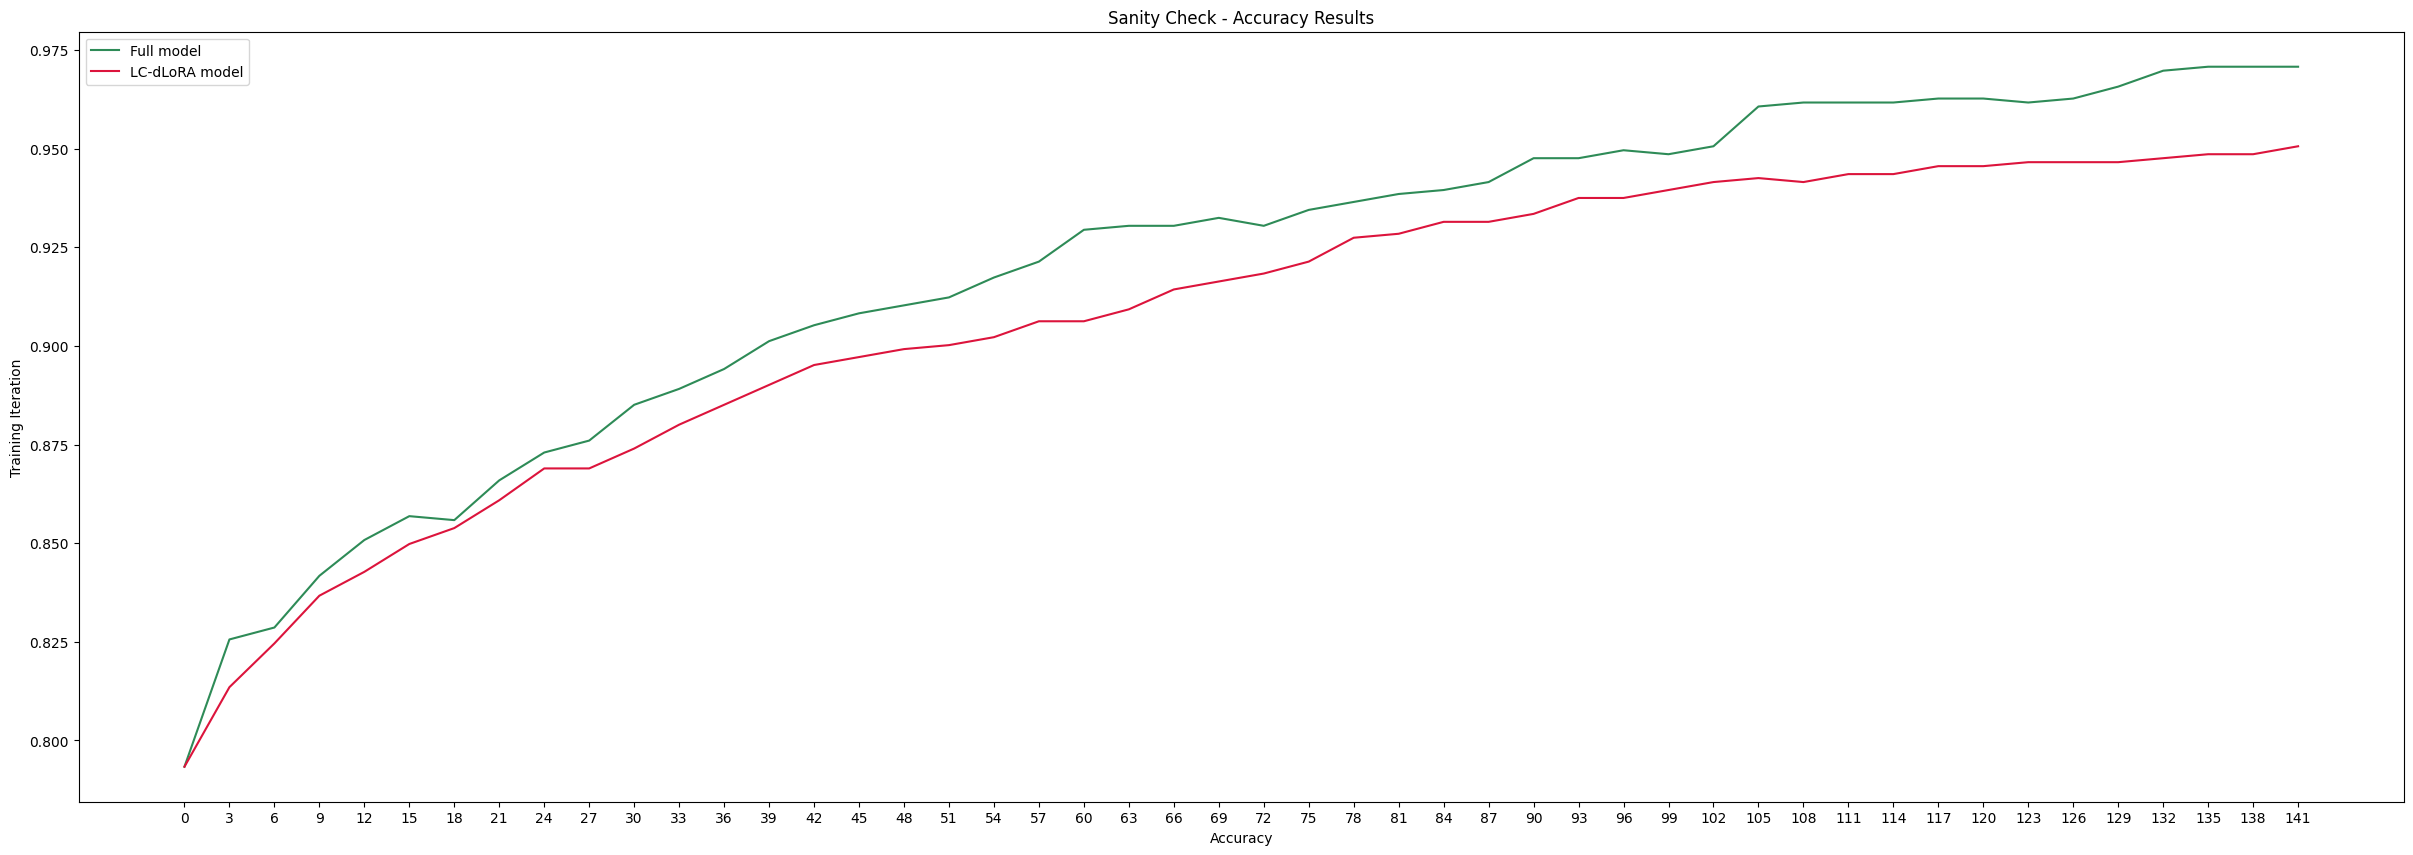

In [35]:
set_no = len(full_acc) * 3
tick_markers = [x for x in range(0, set_no, 3)]
tick_positions = [x for x in range(0, len(full_acc))]

plt.figure(figsize=(30, 10))
plt.title("Sanity Check - Accuracy Results")
plt.plot(full_acc, label="Full model", color="seagreen")
plt.plot(lora_acc, label="LC-dLoRA model", color="crimson")
plt.xticks(tick_positions, tick_markers)
plt.xlabel("Accuracy")
plt.ylabel("Training Iteration")
plt.legend()
plt.show()

# 5. Sanity Check on Trainer Class

In [ ]:
from lc_dlora import Trainer

# Load the same branch model
branch_model = NeuralNetwork()
branch_model.load_state_dict(torch.load("/volumes/Ultra Touch/dlora/branchpoints/model_0.7913306451612904.pt"))

trainer = Trainer(config=SYNTHETIC_DATASET_CONFIG)
trainer.train(model=branch_model, train_loader=train_loader, 
              validation_loader=validation_loader)

In [9]:
validation_accuracy_log = trainer.get_evaluation_log()

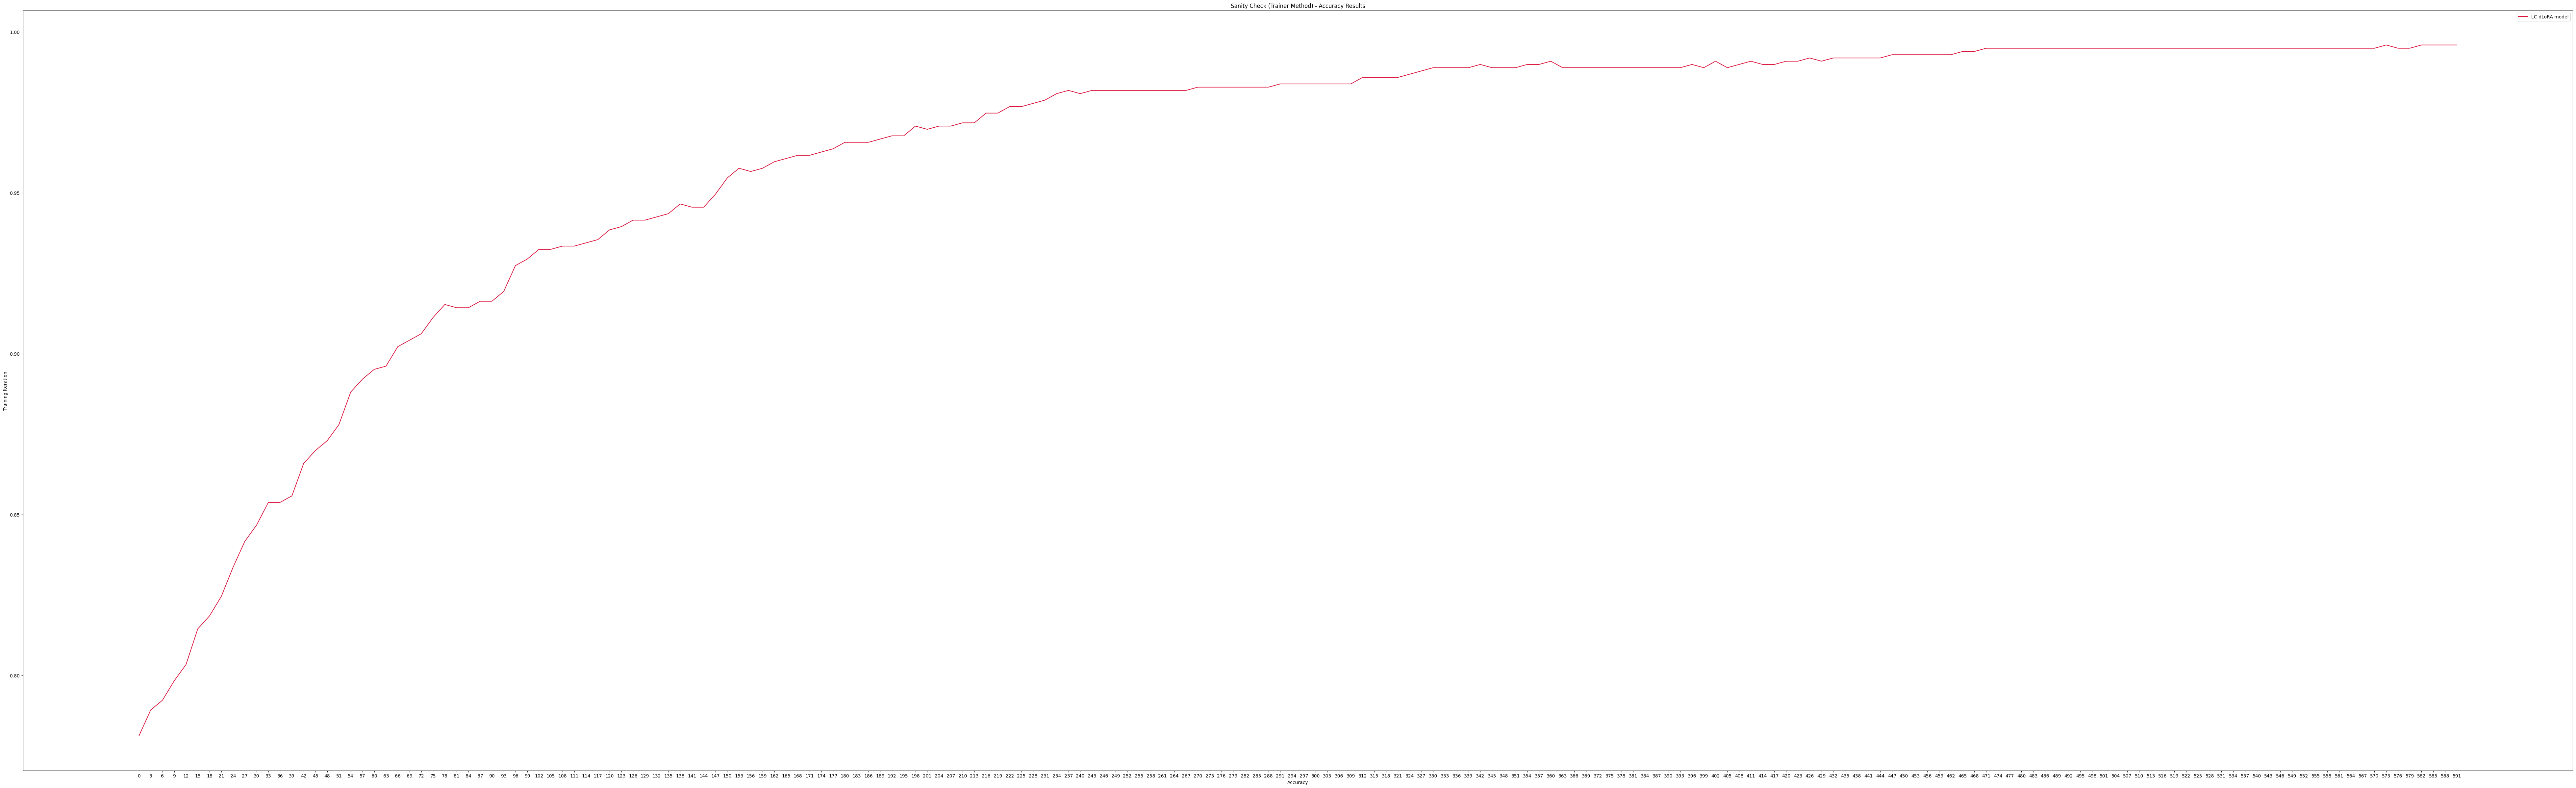

In [15]:
set_no = len(validation_accuracy_log) * 3
tick_markers = [x for x in range(0, set_no, 3)]
tick_positions = [x for x in range(0, len(validation_accuracy_log))]

plt.figure(figsize=(100, 30))
plt.title("Sanity Check (Trainer Method) - Accuracy Results")
plt.plot(validation_accuracy_log, label="LC-dLoRA model", color="crimson")
plt.xticks(tick_positions, tick_markers)
plt.xlabel("Accuracy")
plt.ylabel("Training Iteration")
plt.legend()
plt.show()